# Business/Tech Park in Benagluru City
## Introduction

In this project I have scraped data from various websites about Bengaluru's commercial property price rates and its neighbourhoods.Then I used Foursquare API to get the common venues of the neighbourhoods and then by using K-means clustering I clustered Bengaluru city on the basis of the common venues in an attemot to find the ample location for the construction of a Business/Tech park. I also used the property price data too.


# Importing Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import geocoder as geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import seaborn as sns # visuzlization of data

print('Libraries imported.')

Libraries imported.


# Data Scraping and Wrangling

## Wikipedia's Bengaluru City Neighborhood data scraping and wrangling

In [3]:
e=pd.read_html("https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore",header=0) 
e

[                 Name  Image  \
 0     Cantonment area    NaN   
 1              Domlur    NaN   
 2         Indiranagar    NaN   
 3   Jeevanbheemanagar    NaN   
 4         Malleswaram    NaN   
 5           Pete area    NaN   
 6      Sadashivanagar    NaN   
 7       Seshadripuram    NaN   
 8        Shivajinagar    NaN   
 9              Ulsoor    NaN   
 10      Vasanth Nagar    NaN   
 
                                               Summary  
 0   The Cantonment area in Bangalore was used as a...  
 1   Formerly part of the Cantonment area, Domlur h...  
 2   Indiranagar is a sought-after residential and ...  
 3                                                 NaN  
 4                                                 NaN  
 5   Established by Kempe Gowda I at the time of cr...  
 6   Sadashivanagar is an upscale neighbourhood in ...  
 7   Seshadripuram was established in 1892 to reduc...  
 8   Shivajinagar is one of the older areas of the ...  
 9   Ulsoor (or Halasuru) is one

In [4]:
#mapping the respective neighbourhoods to its zones as given in the wikipeida page
d={"Central":e[0]["Name"], "Eastern" : e[1]["Name"], "North-Eastern": e[2]["Name"], "Northern" : e[3]["Name"], "South-Eastern" : e[4]["Name"],"Southern" : e[5]["Name"], "Southern Suburbs" : e[6]["Name"], "Western" : e[7]["Name"] }
#creating a temporary dtaframe
s=pd.DataFrame.from_dict(d)
print(s.shape)
s.head()

(11, 8)


,Central,Eastern,North-Eastern,Northern,South-Eastern,Southern,Southern Suburbs,Western
0,Cantonment area,Bellandur,Banaswadi,Hebbal,Bommanahalli,Banashankari,Anjanapura,Basaveshwaranagar
1,Domlur,CV Raman Nagar,HBR Layout,Jalahalli,Bommasandra,Basavanagudi,Arekere,Kamakshipalya
2,Indiranagar,Hoodi,Horamavu,Mathikere,BTM Layout,Girinagar,Begur,Kengeri
3,Jeevanbheemanagar,Krishnarajapuram,Kalyan Nagar,Peenya,Electronic City,J. P. Nagar,Gottigere,Mahalakshmi Layout
4,Malleswaram,Mahadevapura,Kammanahalli,R. T. Nagar,HSR Layout,Jayanagar,Hulimavu,Nagarbhavi


In [5]:
#chaning the columns to index
df=s.stack().astype(str).reset_index()
print(df.shape)
df.head()

(65, 3)


,level_0,level_1,0
0,0,Central,Cantonment area
1,0,Eastern,Bellandur
2,0,North-Eastern,Banaswadi
3,0,Northern,Hebbal
4,0,South-Eastern,Bommanahalli


In [6]:
#dropping unnecesary column and renameing columns to the final datframe
ds=df.drop(columns="level_0", axis=1)
data=ds.rename(columns={"level_1" : "Zone", 0: "Neighborhood"})
data.head()

,Zone,Neighborhood
0,Central,Cantonment area
1,Eastern,Bellandur
2,North-Eastern,Banaswadi
3,Northern,Hebbal
4,South-Eastern,Bommanahalli


## Commercial Land Price Data Scraping and wrangling
### Property price data is scraped and wrangled in another notebook since its pretty long. The link to that noebook is https://github.com/krishnaramadas/Coursera_Capstone/blob/master/Commercial%20land%20price%20rates.ipynb

In [7]:
#reading in the csv file of the land price data 
a=pd.read_csv(r"C:\Users\user\Desktop\Coursera_Capstone\price_df.csv")
a.head()

,,Zone,Average Price per Sq/Ft
0,,Central,11428.571429
1,,Eastern,4516.666667
2,,North-Eastern,5447.368421
3,,Northern,8176.470588
4,,South-Eastern,7285.714286


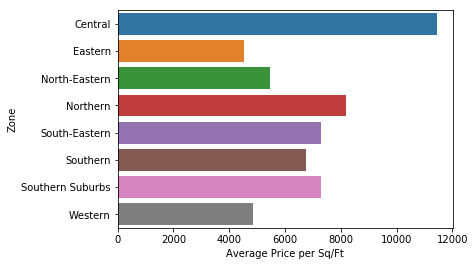

In [8]:
#visualizing the average commercial land price rate of various zones
sns.barplot(x="Average Price per Sq/Ft", y="Zone", data=a)

## Merging the two data frames to a single data frame

In [9]:
dataset=pd.merge(left=data, right=a)
dataset.head()

,Zone,Neighborhood,,Average Price per Sq/Ft
0,Central,Cantonment area,,11428.571429
1,Central,Domlur,,11428.571429
2,Central,Indiranagar,,11428.571429
3,Central,Jeevanbheemanagar,,11428.571429
4,Central,Malleswaram,,11428.571429


## Getting the geo coordinates data of the neighborhoods

In [10]:
#creating a null list
geocords=[]
#getting the geo cordinates data of all the neighborhoods
for neighborhood in dataset["Neighborhood"]:
    g=geocoder.arcgis('{}, Bengaluru, Karnataka'. format(neighborhood))
    geocords.append(g.latlng)
geocords  

[[12.994350000000054, 77.59839000000005],
 [12.943300000000022, 77.65603000000004],
 [12.973930000000053, 77.64390000000003],
 [12.966050000000052, 77.65765000000005],
 [13.006300461771387, 77.56828870495833],
 [12.966870000000029, 77.58734000000004],
 [13.014820000000043, 77.57771000000008],
 [12.993570000000034, 77.57989000000003],
 [12.987190000000055, 77.60400000000004],
 [12.989160000000027, 77.62798000000004],
 [12.990730000000042, 77.58856000000003],
 [12.927350000000047, 77.67184000000003],
 [12.978897518495732, 77.65612938520344],
 [12.991970000000038, 77.71504000000004],
 [13.00040000000007, 77.68378000000007],
 [12.99410000000006, 77.66635000000008],
 [12.954670000000021, 77.70752000000005],
 [12.943480000000022, 77.74703000000005],
 [12.975170000000048, 77.75227000000007],
 [13.028473466463632, 77.63189195846024],
 [13.02642000000003, 77.62432000000007],
 [13.038680000000056, 77.66187000000008],
 [12.96819000000005, 77.52114000000006],
 [13.014280000000042, 77.6367500000000

## Merging the coordinates into the original dataframe

In [11]:
df_geo = pd.DataFrame(geocords, columns=['Latitude', 'Longitude'])
dataset['Latitude'] = df_geo['Latitude']
dataset['Longitude'] = df_geo['Longitude']
print(dataset.shape)


(65, 6)


### Save the DataFrame as CSV file

In [12]:
dataset.to_csv("dataset.csv", index=False)

### Using geopy to obtain the coordinates of Bengaluru city

In [22]:
geolocator = Nominatim(user_agent="bnglr_explorer")
location = geolocator.geocode("Bengaluru, Karnataka")
latitude = location.latitude
longitude = location.longitude
print("The geograpical coordinate of Bengaluru are " , (latitude, longitude))

The geograpical coordinate of Bengaluru are  (12.9791198, 77.5912997)


## Create a map of Bengaluru City with neighborhoods superimposed on top

In [23]:
import folium
map_bnglr = folium.Map(location=[latitude, longitude], zoom_start=11.25)

# add markers to map
for lat, lng, zone, neighborhood in zip(dataset['Latitude'], dataset['Longitude'], dataset['Zone'], dataset['Neighborhood']):
    label = '{}, {}'.format(neighborhood, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#FFC300',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bnglr)  
    
map_bnglr

## Define Foursquare Credentials and Version

In [24]:
#the credentials for the FourSquare API
CLIENT_ID = 'YEE0QJOS2BTZZQIDVFFVY2MCWPZ3UILVFWLPGNJARUAF4NPG' 
CLIENT_SECRET = 'RJIQPOGHLTLLCIDO5QTSBJOIS3RXDIBFUZVQ1R5VUTUQQKQJ' 
VERSION = '20180605' 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YEE0QJOS2BTZZQIDVFFVY2MCWPZ3UILVFWLPGNJARUAF4NPG
CLIENT_SECRET:RJIQPOGHLTLLCIDO5QTSBJOIS3RXDIBFUZVQ1R5VUTUQQKQJ


### Defing a funtion to exploring neighborhoods in our dataframe and cleaning the resulting json file and structure it into a pandas dataframe

In [25]:
def Venues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
bnglr_venues = Venues(names=dataset['Neighborhood'],latitudes=dataset['Latitude'],longitudes=dataset['Longitude'])

Cantonment area
Domlur
Indiranagar
Jeevanbheemanagar
Malleswaram
Pete area
Sadashivanagar
Seshadripuram
Shivajinagar
Ulsoor
Vasanth Nagar
Bellandur
CV Raman Nagar
Hoodi
Krishnarajapuram
Mahadevapura
Marathahalli
Varthur
Whitefield
Banaswadi
HBR Layout
Horamavu
Kalyan Nagar
Kammanahalli
Lingarajapuram
Ramamurthy Nagar
Hebbal
Jalahalli
Mathikere
Peenya
R. T. Nagar
Vidyaranyapura
Yelahanka
Yeshwanthpur
Bommanahalli
Bommasandra
BTM Layout
Electronic City
HSR Layout
Koramangala
Madiwala
Banashankari
Basavanagudi
Girinagar
J. P. Nagar
Jayanagar
Kumaraswamy Layout
Padmanabhanagar
Uttarahalli
Anjanapura
Arekere
Begur
Gottigere
Hulimavu
Kothnur
Basaveshwaranagar
Kamakshipalya
Kengeri
Mahalakshmi Layout
Nagarbhavi
Nandini Layout
Nayandahalli
Rajajinagar
Rajarajeshwari Nagar
Vijayanagar


In [27]:
bnglr_venues

,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cantonment area,12.994350,77.598390,Jayamahal Palace Hotel,12.996839,77.597163,Indian Restaurant
1,Cantonment area,12.994350,77.598390,Ujwal Bar & Restaurant,12.992280,77.594473,Indian Restaurant
2,Cantonment area,12.994350,77.598390,Alliance Française,12.991232,77.596723,Concert Hall
3,Cantonment area,12.994350,77.598390,Jaymahal Palace Grounds,12.995299,77.596934,Music Venue
4,Cantonment area,12.994350,77.598390,Watson's,12.994218,77.594645,Pub
5,Cantonment area,12.994350,77.598390,Jayamahal Palace,12.996887,77.597217,Event Space
6,Cantonment area,12.994350,77.598390,Pai Vihar,12.993172,77.595887,Indian Restaurant
7,Cantonment area,12.994350,77.598390,Cantonment Station Chai Guy,12.993795,77.598244,Tea Room
8,Cantonment area,12.994350,77.598390,Featherlite collections,12.993066,77.595541,Furniture / Home Store
9,Indiranagar,12.973930,77.643900,eclipse lounge,12.973695,77.644001,Lounge


### Venues returned for each Neighborhood Location

In [28]:
bnglr_venues.groupby('Neighborhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Anjanapura,2,2,2,2,2,2
Arekere,18,18,18,18,18,18
BTM Layout,33,33,33,33,33,33
Banashankari,12,12,12,12,12,12
Banaswadi,11,11,11,11,11,11
Basavanagudi,14,14,14,14,14,14
Basaveshwaranagar,5,5,5,5,5,5
Begur,2,2,2,2,2,2
Bellandur,27,27,27,27,27,27


In [29]:
print('There are {} uniques categories.'.format(len(bnglr_venues['Venue Category'].unique())))

There are 133 uniques categories.


## Analyzing each Neighborhood Location

In [48]:
# one hot encoding
bnglr_onehot = pd.get_dummies(bnglr_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bnglr_onehot['Neighborhood'] = bnglr_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bnglr_onehot.columns[-1]] + list(bnglr_onehot.columns[:-1])
bnglr_onehot = bnglr_onehot[fixed_columns]

bnglr_onehot.head()

,Yoga Studio,ATM,Accessories Store,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Bed & Breakfast,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Camera Store,Candy Store,Chaat Place,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Film Studio,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Kids Store,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Venue,Neighborhood,New American Restaurant,Nightclub,North Indian Restaurant,Office,Optical Shop,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Rajasthani Restaurant,Resort,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Tailor Shop,Tea Room,Toy / Game Store,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cantonment area,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cantonment area,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cantonment area,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Cantonment area,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cantonment area,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
bnglr_onehot.shape

(590, 133)

### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [50]:
bnglr_grouped = bnglr_onehot.groupby('Neighborhood').mean().reset_index()
bnglr_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Bed & Breakfast,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Camera Store,Candy Store,Chaat Place,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Film Studio,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Kids Store,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Office,Optical Shop,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Rajasthani Restaurant,Resort,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Tailor Shop,Tea Room,Toy / Game Store,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Women's Store
0,Anjanapura,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Arekere,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.055556,0.055556,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.0000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.0,0.055556,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.055556,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [51]:
k=bnglr_grouped
k.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Bed & Breakfast,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Café,Camera Store,Candy Store,Chaat Place,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Falafel Restaurant,Fast Food Restaurant,Film Studio,Flea Market,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Gastropub,General Entertainment,German Restaurant,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Kids Store,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Miscellaneous Shop,Motorcycle Shop,Mughlai Restaurant,Multicuisine Indian Restaurant,Multiplex,Music Venue,New American Restaurant,Nightclub,North Indian Restaurant,Office,Optical Shop,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Punjabi Restaurant,Rajasthani Restaurant,Resort,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Tailor Shop,Tea Room,Toy / Game Store,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Women's Store
0,Anjanapura,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Arekere,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.0,0.0,0.055556,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.055556,0.000000,0.0,0.0,0.0,0.055556,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055556,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.000000,0.0,0.0,0.055556,0.111111,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.222222,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,BTM Layout,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.090909,0.0,0.0,0.0,0.060606,0.000000,0.0,0.030303,0.0,0.0,0.0,0.0,0.030303,0.0,0.030303,0.000000,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.000000,0.000000,0.0,0.0,0.090909,0.181818,0.0,0.0,0.030303,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.060606,0.000000,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.

In [52]:
k.shape

(62, 133)

### Top 5 most common venues for each Neighborhood

In [53]:
num_top_venues = 5

for hood in k['Neighborhood']:
    print("----"+hood+"----")
    temp = k[k['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Anjanapura----
                            venue  freq
0                             ATM   0.5
1                            Pool   0.5
2         North Indian Restaurant   0.0
3              Mughlai Restaurant   0.0
4  Multicuisine Indian Restaurant   0.0


----Arekere----
                 venue  freq
0  Sporting Goods Shop  0.22
1    Indian Restaurant  0.11
2               Bakery  0.06
3     Business Service  0.06
4     Department Store  0.06


----BTM Layout----
                  venue  freq
0     Indian Restaurant  0.18
1  Fast Food Restaurant  0.09
2           Snack Place  0.09
3                Bakery  0.09
4        Ice Cream Shop  0.09


----Banashankari----
                   venue  freq
0                  Diner  0.17
1         Ice Cream Shop  0.17
2                 Bakery  0.17
3  Performing Arts Venue  0.08
4   Fast Food Restaurant  0.08


----Banaswadi----
                     venue  freq
0        Indian Restaurant  0.18
1  South Indian Restaurant  0.09
2         Halal Rest

                            venue  freq
0                             Gym   1.0
1                     Yoga Studio   0.0
2         North Indian Restaurant   0.0
3              Mughlai Restaurant   0.0
4  Multicuisine Indian Restaurant   0.0


----Nandini Layout----
               venue  freq
0  Indian Restaurant  0.33
1                ATM  0.17
2               Café  0.17
3               Park  0.17
4               Pool  0.17


----Nayandahalli----
                venue  freq
0                 ATM   0.5
1  Miscellaneous Shop   0.5
2           Nightclub   0.0
3     Motorcycle Shop   0.0
4  Mughlai Restaurant   0.0


----Padmanabhanagar----
                  venue  freq
0     Convenience Store   0.2
1     Indian Restaurant   0.2
2                Bakery   0.2
3  Fast Food Restaurant   0.2
4           Snack Place   0.2


----Peenya----
                   venue  freq
0                   Café   1.0
1            Yoga Studio   0.0
2        Motorcycle Shop   0.0
3  Performing Arts Venue   0.0
4   

### Add top venues to a data frame

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = k['Neighborhood']

for ind in np.arange(k.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(k.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anjanapura,ATM,Pool,Women's Store,Diner,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Donut Shop,Dessert Shop
1,Arekere,Sporting Goods Shop,Indian Restaurant,Gym / Fitness Center,Mughlai Restaurant,Department Store,Chinese Restaurant,Pizza Place,Business Service,Bus Line,Bar
2,BTM Layout,Indian Restaurant,Bakery,Ice Cream Shop,Fast Food Restaurant,Café,Snack Place,Sandwich Place,Chinese Restaurant,Vegetarian / Vegan Restaurant,Restaurant
3,Banashankari,Diner,Ice Cream Shop,Bakery,Indian Restaurant,Seafood Restaurant,Café,Asian Restaurant,Performing Arts Venue,Fast Food Restaurant,Dim Sum Restaurant
4,Banaswadi,Indian Restaurant,Jewelry Store,Liquor Store,South Indian Restaurant,Kids Store,Juice Bar,Karnataka Restaurant,Pizza Place,Clothing Store,Halal Restaurant
5,Basavanagudi,Indian Restaurant,Fast Food Restaurant,Breakfast Spot,Sandwich Place,Restaurant,Department Store,Bakery,Plaza,Donut Shop,Electronics Store
6,Basaveshwaranagar,Indian Restaurant,Gym,Pizza Place,Fast Food Restaurant,Ice Cream Shop,Gym / Fitness Center,Event Space,Hotel,Concert Hall,Convenience Store
7,Begur,Badminton Court,Lake,Women's Store,Eastern European Restaurant,Fast Food Restaurant,Falafel Restaurant,Event Space,Electronics Store,Donut Shop,Flea Market
8,Bellandur,Indian Restaurant,Fast Food Restaurant,Café,Pizza Place,Kerala Restaurant,Bakery,Coffee Shop,Dessert Shop,Multiplex,Shopping Mall
9,Bommanahalli,Indian Restaurant,Department Store,Flea Market,Convenience Store,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop


## Adding Average Commercial land price of each Neighborhood in the Group

In [56]:
k["Price"]= dataset["Average Price per Sq/Ft"]

## Clustering Neighborhoods
### Setting the dataframe for k-means clustering to operate on

In [57]:
bnglr_grouped_clustering = k.drop('Neighborhood', 1)

#### Using K-Means clustering

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [59]:
max_range = 20 # Maximum range of clusters

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    bgc = bnglr_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(bgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(bgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

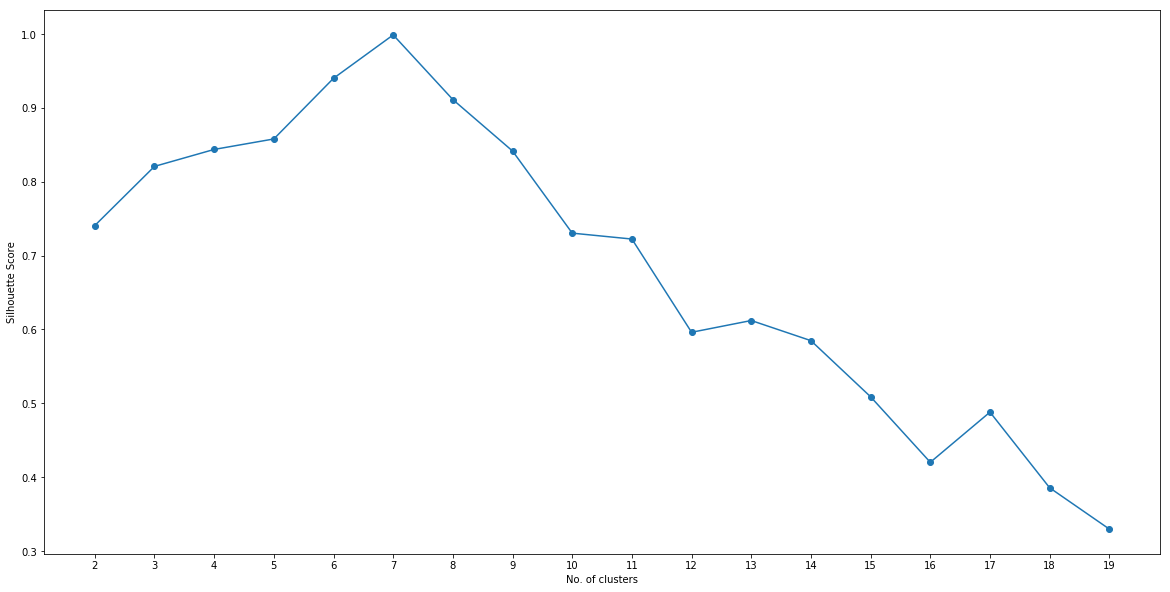

In [61]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

#### From the graph the optimal number is found out to be considered for our clustering

In [62]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt

7

#### K-Means clustering for the optimal number of clusters

In [63]:
kclusters = opt

# Run k-means clustering
bgc = bnglr_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(bgc)
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [64]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bnglr_merged = pd.merge(left= dataset, right=neighborhoods_venues_sorted)

bnglr_merged

,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central,Cantonment area,,11428.571429,12.994350,77.598390,6,Indian Restaurant,Tea Room,Pub,Music Venue,Event Space,Furniture / Home Store,Concert Hall,Golf Course,Electronics Store,Convenience Store
1,Central,Indiranagar,,11428.571429,12.973930,77.643900,5,Indian Restaurant,Café,Pub,Lounge,Ice Cream Shop,Cupcake Shop,Cocktail Bar,Bar,Bakery,Deli / Bodega
2,Central,Jeevanbheemanagar,,11428.571429,12.966050,77.657650,5,Indian Restaurant,Dessert Shop,Bakery,Café,Department Store,Deli / Bodega,Dim Sum Restaurant,Diner,Flea Market,Donut Shop
3,Central,Malleswaram,,11428.571429,13.006300,77.568289,4,Ice Cream Shop,Indian Restaurant,Coffee Shop,Café,South Indian Restaurant,Chinese Restaurant,Dessert Shop,Camera Store,Donut Shop,Flea Market
4,Central,Pete area,,11428.571429,12.966870,77.587340,0,Indian Restaurant,Electronics Store,Rajasthani Restaurant,Bagel Shop,Breakfast Spot,Platform,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
5,Central,Sadashivanagar,,11428.571429,13.014820,77.577710,4,Hotel,Bed & Breakfast,Playground,Liquor Store,Women's Store,Donut Shop,Falafel Restaurant,Event Space,Electronics Store,Eastern European Restaurant
6,Central,Seshadripuram,,11428.571429,12.993570,77.579890,4,Art Gallery,Indian Restaurant,Chaat Place,Lounge,Asian Restaurant,Hotel,Food & Drink Shop,Dessert Shop,Department Store,Deli / Bodega
7,Central,Shivajinagar,,11428.571429,12.987190,77.604000,4,Indian Restaurant,Tea Room,Café,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Convenience Store,Film Studio,Dim Sum Restaurant
8,Central,Ulsoor,,11428.571429,12.989160,77.627980,4,Café,Paper / Office Supplies Store,Department Store,Women's Store,Film Studio,Cupcake Shop,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner
9,Central,Vasanth Nagar,,11428.571429,12.990730,77.588560,2,Coffee Shop,Hotel,Restaurant,Café,Indian Restaurant,Snack Place,Vegetarian / Vegan Restaurant,Nightclub,Golf Course,Chinese Restaurant


#### The null values in the data is dropped by default of inner join

In [65]:
bnglr_merged.dtypes

Zone                        object
Neighborhood                object
                            object
Average Price per Sq/Ft    float64
Latitude                   float64
Longitude                  float64
Cluster Labels               int32
1st Most Common Venue       object
2nd Most Common Venue       object
3rd Most Common Venue       object
4th Most Common Venue       object
5th Most Common Venue       object
6th Most Common Venue       object
7th Most Common Venue       object
8th Most Common Venue       object
9th Most Common Venue       object
10th Most Common Venue      object
dtype: object

## Visualize the clusters

In [92]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.35)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bnglr_merged['Latitude'],bnglr_merged['Longitude'], bnglr_merged['Neighborhood'], bnglr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Binning
### There is a range of Avg price values so binned the price into 5 distinct values
#### ('Low level ', 'Below Average', 'Average level ','Above Average','High level')

Text(0.5,1,'Price bins')

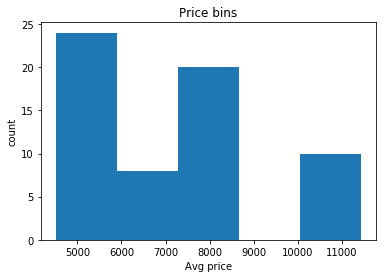

In [67]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(bnglr_merged["Average Price per Sq/Ft"],bins=5)

# set x/y labels and plot title
plt.pyplot.xlabel("Avg price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price bins")

In [68]:
bins = np.linspace(min(bnglr_merged["Average Price per Sq/Ft"]), max(bnglr_merged["Average Price per Sq/Ft"]), 6)
bins

array([ 4516.66666667,  5899.04761905,  7281.42857143,  8663.80952381,
       10046.19047619, 11428.57142857])

In [69]:
group_names = ['Low level ', 'Below Average', 'Average level ','Above Average','High level']

In [70]:
bnglr_merged['Price-Categories'] = pd.cut(bnglr_merged['Average Price per Sq/Ft'], bins, labels=group_names, include_lowest=True )
bnglr_merged[['Average Price per Sq/Ft','Price-Categories']].head()

,Average Price per Sq/Ft,Price-Categories
0,11428.571429,High level
1,11428.571429,High level
2,11428.571429,High level
3,11428.571429,High level
4,11428.571429,High level


## Final Data

In [71]:
bnglr_merged.drop(columns=['6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue'],inplace=True)

bnglr_merged.head()

,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories
0,Central,Cantonment area,,11428.571429,12.99435,77.598390,6,Indian Restaurant,Tea Room,Pub,Music Venue,Event Space,High level
1,Central,Indiranagar,,11428.571429,12.97393,77.643900,5,Indian Restaurant,Café,Pub,Lounge,Ice Cream Shop,High level
2,Central,Jeevanbheemanagar,,11428.571429,12.96605,77.657650,5,Indian Restaurant,Dessert Shop,Bakery,Café,Department Store,High level
3,Central,Malleswaram,,11428.571429,13.00630,77.568289,4,Ice Cream Shop,Indian Restaurant,Coffee Shop,Café,South Indian Restaurant,High level
4,Central,Pete area,,11428.571429,12.96687,77.587340,0,Indian Restaurant,Electronics Store,Rajasthani Restaurant,Bagel Shop,Breakfast Spot,High level


## Examining the Clusters
### Cluster 1


In [84]:
C1=bnglr_merged[bnglr_merged['Cluster Labels']==0]
print("The Average Commercial Land Price =",C1['Average Price per Sq/Ft'].mean())
C1

The Average Commercial Land Price = 6743.083812472358


,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories
4,Central,Pete area,,11428.571429,12.96687,77.58734,0,Indian Restaurant,Electronics Store,Rajasthani Restaurant,Bagel Shop,Breakfast Spot,High level
27,Northern,Peenya,,8176.470588,13.03184,77.52677,0,Café,Women's Store,Flea Market,Cupcake Shop,Deli / Bodega,Average level
28,Northern,R. T. Nagar,,8176.470588,13.02447,77.59587,0,Indian Restaurant,Pizza Place,Food Truck,Chinese Restaurant,Resort,Average level
45,Southern,Padmanabhanagar,,6763.157895,12.91547,77.55311,0,Indian Restaurant,Bakery,Convenience Store,Fast Food Restaurant,Snack Place,Below Average
57,Western,Nagarbhavi,,4850.000000,12.95624,77.50933,0,Gym,Women's Store,Diner,Fast Food Restaurant,Falafel Restaurant,Low level
58,Western,Nandini Layout,,4850.000000,13.01480,77.53890,0,Indian Restaurant,Pool,Café,Park,ATM,Low level
59,Western,Nayandahalli,,4850.000000,12.94205,77.52101,0,ATM,Miscellaneous Shop,Women's Store,Donut Shop,Fast Food Restaurant,Low level
60,Western,Rajajinagar,,4850.000000,13.00543,77.55682,0,Women's Store,Italian Restaurant,Pizza Place,Pub,Electronics Store,Low level


## Cluster 2

In [86]:
C2=bnglr_merged[bnglr_merged['Cluster Labels']==1]
print("The Average Commercial Land Price =",C2['Average Price per Sq/Ft'].mean())
C2

The Average Commercial Land Price = 6550.421508316243


,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories
10,Eastern,Bellandur,,4516.666667,12.927350,77.671840,1,Indian Restaurant,Fast Food Restaurant,Café,Pizza Place,Kerala Restaurant,Low level
18,North-Eastern,Banaswadi,,5447.368421,13.028473,77.631892,1,Indian Restaurant,Jewelry Store,Liquor Store,South Indian Restaurant,Kids Store,Low level
32,South-Eastern,Bommanahalli,,7285.714286,12.903070,77.624410,1,Indian Restaurant,Department Store,Flea Market,Convenience Store,Cupcake Shop,Average level
33,South-Eastern,Bommasandra,,7285.714286,12.817540,77.678790,1,Indian Restaurant,ATM,Donut Shop,Film Studio,Fast Food Restaurant,Average level
34,South-Eastern,BTM Layout,,7285.714286,12.914890,77.610040,1,Indian Restaurant,Bakery,Ice Cream Shop,Fast Food Restaurant,Café,Average level
39,Southern,Banashankari,,6763.157895,12.922280,77.569860,1,Diner,Ice Cream Shop,Bakery,Indian Restaurant,Seafood Restaurant,Below Average
40,Southern,Basavanagudi,,6763.157895,12.939000,77.571350,1,Indian Restaurant,Fast Food Restaurant,Breakfast Spot,Sandwich Place,Restaurant,Below Average
47,Southern Suburbs,Anjanapura,,7285.714286,12.858100,77.559060,1,ATM,Pool,Women's Store,Diner,Falafel Restaurant,Average level
48,Southern Suburbs,Arekere,,7285.714286,12.885640,77.596690,1,Sporting Goods Shop,Indian Restaurant,Gym / Fitness Center,Mughlai Restaurant,Department Store,Average level
49,Southern Suburbs,Begur,,7285.714286,12.882490,77.624750,1,Badminton Court,Lake,Women's Store,Eastern European Restaurant,Fast Food Restaurant,Average level


## Cluster 3

In [87]:
C3=bnglr_merged[bnglr_merged['Cluster Labels']==2]
print("The Average Commercial Land Price =",C3['Average Price per Sq/Ft'].mean())
C3

The Average Commercial Land Price = 7393.496345906785


,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories
9,Central,Vasanth Nagar,,11428.571429,12.99073,77.58856,2,Coffee Shop,Hotel,Restaurant,Café,Indian Restaurant,High level
16,Eastern,Varthur,,4516.666667,12.94348,77.74703,2,Indian Restaurant,Department Store,Lake,Donut Shop,Fast Food Restaurant,Low level
17,Eastern,Whitefield,,4516.666667,12.97517,77.75227,2,Hotel,Indian Restaurant,Chinese Restaurant,Market,Eastern European Restaurant,Low level
29,Northern,Vidyaranyapura,,8176.470588,13.07927,77.55912,2,Pizza Place,Indian Restaurant,Bus Station,Chinese Restaurant,Department Store,Average level
30,Northern,Yelahanka,,8176.470588,13.09932,77.59260,2,Smoke Shop,Ice Cream Shop,American Restaurant,Train Station,Chinese Restaurant,Average level
31,Northern,Yeshwanthpur,,8176.470588,13.02954,77.54022,2,Indian Restaurant,Spa,Wine Bar,Food Court,Light Rail Station,Average level
46,Southern,Uttarahalli,,6763.157895,12.89760,77.52822,2,Park,Film Studio,Tailor Shop,Convenience Store,Cupcake Shop,Below Average


## Cluster 4

In [88]:
C4=bnglr_merged[bnglr_merged['Cluster Labels']==3]
print("The Average Commercial Land Price =",C4['Average Price per Sq/Ft'].mean())
C4

The Average Commercial Land Price = 5805.748746867167


,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories
13,Eastern,Krishnarajapuram,,4516.666667,13.00040,77.68378,3,Ice Cream Shop,Intersection,Bus Station,Diner,Falafel Restaurant,Low level
21,North-Eastern,Kalyan Nagar,,5447.368421,12.96819,77.52114,3,Indian Restaurant,Nightclub,Bus Station,Café,Supermarket,Low level
22,North-Eastern,Kammanahalli,,5447.368421,13.01428,77.63675,3,Kerala Restaurant,Indian Restaurant,Burger Joint,Juice Bar,Fast Food Restaurant,Low level
37,South-Eastern,Koramangala,,7285.714286,12.92005,77.62543,3,Indian Restaurant,Park,Film Studio,Convenience Store,Cupcake Shop,Average level
44,Southern,Kumaraswamy Layout,,6763.157895,12.89818,77.55929,3,Market,Fast Food Restaurant,Bakery,Chaat Place,Café,Below Average
52,Southern Suburbs,Kothnur,,7285.714286,13.06434,77.64853,3,Convenience Store,Gym / Fitness Center,Pizza Place,Italian Restaurant,Coffee Shop,Average level
54,Western,Kamakshipalya,,4850.000000,12.98699,77.52482,3,Hotel,Bus Station,Women's Store,Donut Shop,Fast Food Restaurant,Low level
55,Western,Kengeri,,4850.000000,12.90872,77.48719,3,Indian Restaurant,Bar,Sports Club,Flea Market,Fast Food Restaurant,Low level


## Cluster 5

In [89]:
C5=bnglr_merged[bnglr_merged['Cluster Labels']==4]
print("The Average Commercial Land Price =",C5['Average Price per Sq/Ft'].mean())
C5

The Average Commercial Land Price = 7864.085553249641


,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories
3,Central,Malleswaram,,11428.571429,13.00630,77.568289,4,Ice Cream Shop,Indian Restaurant,Coffee Shop,Café,South Indian Restaurant,High level
5,Central,Sadashivanagar,,11428.571429,13.01482,77.577710,4,Hotel,Bed & Breakfast,Playground,Liquor Store,Women's Store,High level
6,Central,Seshadripuram,,11428.571429,12.99357,77.579890,4,Art Gallery,Indian Restaurant,Chaat Place,Lounge,Asian Restaurant,High level
7,Central,Shivajinagar,,11428.571429,12.98719,77.604000,4,Indian Restaurant,Tea Room,Café,Cupcake Shop,Deli / Bodega,High level
8,Central,Ulsoor,,11428.571429,12.98916,77.627980,4,Café,Paper / Office Supplies Store,Department Store,Women's Store,Film Studio,High level
14,Eastern,Mahadevapura,,4516.666667,12.99410,77.666350,4,Pizza Place,Shopping Mall,Snack Place,Department Store,Dessert Shop,Low level
15,Eastern,Marathahalli,,4516.666667,12.95467,77.707520,4,Indian Restaurant,Sports Bar,Pizza Place,Bakery,Department Store,Low level
23,North-Eastern,Lingarajapuram,,5447.368421,13.00555,77.625970,4,Convenience Store,New American Restaurant,Café,Hotel,Cupcake Shop,Low level
24,North-Eastern,Ramamurthy Nagar,,5447.368421,13.02378,77.677870,4,Indian Restaurant,Supermarket,Bakery,IT Services,ATM,Low level
26,Northern,Mathikere,,8176.470588,13.03236,77.558650,4,Indian Restaurant,Fast Food Restaurant,Diner,Bus Station,Bakery,Average level


## Cluster 6

In [90]:
C6=bnglr_merged[bnglr_merged['Cluster Labels']==5]
print("The Average Commercial Land Price =",C6['Average Price per Sq/Ft'].mean())
C6

The Average Commercial Land Price = 7661.88686000716


,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories
1,Central,Indiranagar,,11428.571429,12.97393,77.64390,5,Indian Restaurant,Café,Pub,Lounge,Ice Cream Shop,High level
2,Central,Jeevanbheemanagar,,11428.571429,12.96605,77.65765,5,Indian Restaurant,Dessert Shop,Bakery,Café,Department Store,High level
12,Eastern,Hoodi,,4516.666667,12.99197,77.71504,5,Indian Restaurant,Furniture / Home Store,Yoga Studio,Vegetarian / Vegan Restaurant,IT Services,Low level
20,North-Eastern,Horamavu,,5447.368421,13.03868,77.66187,5,Warehouse Store,Women's Store,Diner,Fast Food Restaurant,Falafel Restaurant,Low level
42,Southern,J. P. Nagar,,6763.157895,12.90831,77.59017,5,Indian Restaurant,Fast Food Restaurant,Coffee Shop,Café,Bakery,Below Average
43,Southern,Jayanagar,,6763.157895,12.92870,77.58279,5,Indian Restaurant,Café,Juice Bar,Fast Food Restaurant,Sandwich Place,Below Average
51,Southern Suburbs,Hulimavu,,7285.714286,12.88063,77.60146,5,Halal Restaurant,Women's Store,Diner,Fast Food Restaurant,Falafel Restaurant,Average level


## Cluster 7

In [91]:
C7=bnglr_merged[bnglr_merged['Cluster Labels']==6]
print("The Average Commercial Land Price =",C7['Average Price per Sq/Ft'].mean())
C7

The Average Commercial Land Price = 7273.672232050714


,Zone,Neighborhood,,Average Price per Sq/Ft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories
0,Central,Cantonment area,,11428.571429,12.994350,77.598390,6,Indian Restaurant,Tea Room,Pub,Music Venue,Event Space,High level
11,Eastern,CV Raman Nagar,,4516.666667,12.978898,77.656129,6,Indian Restaurant,Office,Food Truck,Sandwich Place,Coffee Shop,Low level
19,North-Eastern,HBR Layout,,5447.368421,13.026420,77.624320,6,Indian Restaurant,Shopping Mall,Optical Shop,Department Store,Donut Shop,Low level
25,Northern,Hebbal,,8176.470588,13.049690,77.589510,6,Café,Food Court,Fast Food Restaurant,Bakery,Women's Store,Average level
35,South-Eastern,Electronic City,,7285.714286,12.845470,77.664300,6,Indian Restaurant,Hotel,Food Court,Bakery,Ice Cream Shop,Average level
36,South-Eastern,HSR Layout,,7285.714286,12.912160,77.644900,6,Indian Restaurant,Café,Pizza Place,Bakery,Gym / Fitness Center,Average level
41,Southern,Girinagar,,6763.157895,12.942780,77.541210,6,Smoke Shop,Fast Food Restaurant,Breakfast Spot,Park,Donut Shop,Below Average
50,Southern Suburbs,Gottigere,,7285.714286,12.855660,77.585500,6,Indian Restaurant,Department Store,Pharmacy,Accessories Store,Flea Market,Average level
